In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='0'

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from tensorflow import keras
import tensorflow as tf

from model_DbyDeep_train import get_npy_DbyDeep

2022-12-19 19:19:26.419203: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-12-19 19:19:27.315310: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-19 19:19:27.316166: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-12-19 19:19:27.356380: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:af:00.0 name: NVIDIA RTX A6000 computeCapability: 8.6
coreClock: 1.8GHz coreCount: 84 deviceMemorySize: 47.54GiB deviceMemoryBandwidth: 715.34GiB/s
2022-12-19 19:19:27.356410: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-12-19 19:19:27.359197: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-1

In [3]:
# gpu setting
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*4)])
    except RuntimeError as e:
        print(e)

# HPP

In [4]:
print('Loading model...')
model = keras.models.load_model("log/model_DbyDeep_05_False.h5")
model.summary()

Loading model...


2022-12-19 19:22:06.011524: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-19 19:22:06.015316: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-19 19:22:06.016747: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:af:00.0 name: NVIDIA RTX A6000 computeCapability: 8.6
coreClock: 1.8GHz coreCount: 84 deviceMemorySize: 47.54GiB deviceMemoryBandwidth: 715.34GiB/s
2022-12-19 19:22:06.016815: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-12-19 19:22:06.016837: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Succ

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 15)]         0                                            
______________________________________________________________________________________________

In [5]:
df_hpp = pd.read_csv('/data/2021_SJH_detectability/data_human/HPP.csv')
df_hpp.rename({'Class':'label'}, axis=1, inplace=True)

In [6]:
print('Loading input peptides')
pep_hpp, n_hpp, c_hpp, m1_hpp, m2_hpp, label_hpp = get_npy_DbyDeep(df_hpp)

print('Making predictions')
model_pred = model.predict([pep_hpp, n_hpp, c_hpp, m1_hpp, m2_hpp])

Loading input peptides
Making predictions


2022-12-19 19:22:13.829621: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-19 19:22:13.851491: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3000000000 Hz
2022-12-19 19:22:21.310995: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-12-19 19:22:22.000973: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-12-19 19:22:22.077865: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-12-19 19:22:22.078174: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


In [7]:
df_hpp = pd.concat([df_hpp, pd.DataFrame(model_pred, columns=['probs'])['probs']], axis=1)

pe = df_hpp.loc[df_hpp['label']=='PE1'][['peptide', 'probs']].drop_duplicates()
dmp = df_hpp.loc[df_hpp['label']=='Detected_MPs'][['peptide', 'probs']].drop_duplicates()
mp = df_hpp.loc[df_hpp['label']=='MPs'][['peptide', 'probs']].drop_duplicates()

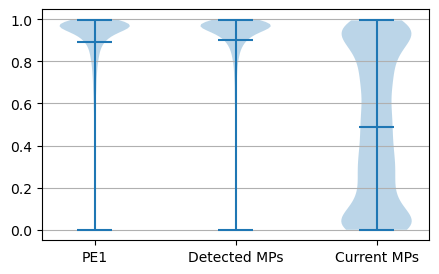

In [8]:
plt.figure(figsize=(5,3))
a = plt.violinplot([pe.probs.astype(float), 
                    dmp.probs.astype(float), 
                    mp.probs.astype(float)],
               showmeans=True,
              )
plt.xticks([y + 1 for y in range(len([pe,dmp,mp]))], ['PE1', 'Detected MPs', 'Current MPs'])
b = plt.grid(axis='y')
plt.show()

TEST Accuracy : 0.8427791861814119
TEST AUC : 0.8549752428721193
              precision    recall  f1-score   support

           0     0.8326    0.5170    0.6379      6234
           1     0.8448    0.9620    0.8996     17039

    accuracy                         0.8428     23273
   macro avg     0.8387    0.7395    0.7687     23273
weighted avg     0.8415    0.8428    0.8295     23273



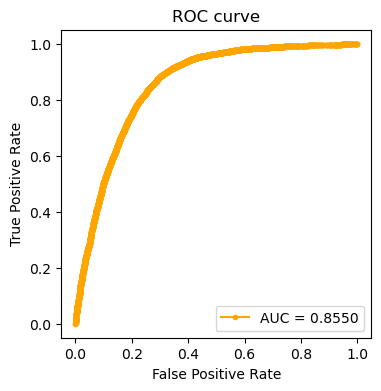

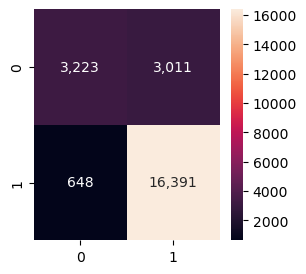

In [9]:
hpp_prob = np.concatenate([pe.probs.values, dmp.probs.values, mp.probs.values])
hpp_pred = np.array([1 if _ >= 0.5 else 0 for _ in hpp_prob])
hpp_true = np.array([1]*len(pe) + [1]*len(dmp) + [0]*len(mp))

auc = roc_auc_score(hpp_true, hpp_prob)
acc = accuracy_score(hpp_true,hpp_pred)
print('TEST Accuracy : {}'.format(acc))
print('TEST AUC : {}'.format(auc))
print(classification_report(hpp_true, hpp_pred, digits=4))


plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(hpp_true, hpp_prob)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(hpp_true, hpp_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

# massIVE-KB

In [10]:
df_test = pd.read_csv('/data/2021_SJH_detectability/data_human/test.csv')

In [11]:
print('Loading input peptides')
pep_test, n_test, c_test, m1_test, m2_test, label_test = get_npy_DbyDeep(df_test)

Loading input peptides


In [12]:
probs = model.predict([pep_test, n_test, c_test, m1_test, m2_test])
y_pred = [1 if i>=0.5 else 0 for i in probs]
loss, acc = model.evaluate([pep_test, n_test, c_test, m1_test, m2_test], label_test)
auc = roc_auc_score(label_test, probs)

5335/5335 [==============================] - 92s 16ms/step - loss: 0.3571 - accuracy: 0.8417


Test Loss: 0.3570958375930786
Test Accuracy: 0.8417395949363708
Test AUC : 0.9209588960990703
              precision    recall  f1-score   support

       False     0.8496    0.8356    0.8425     86495
        True     0.8339    0.8480    0.8409     84211

    accuracy                         0.8417    170706
   macro avg     0.8418    0.8418    0.8417    170706
weighted avg     0.8419    0.8417    0.8417    170706



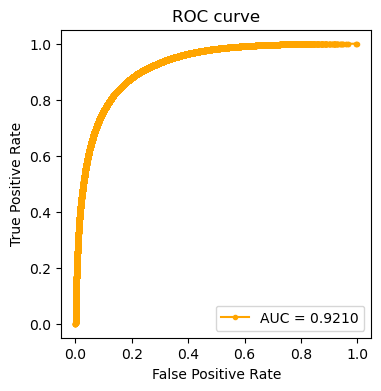

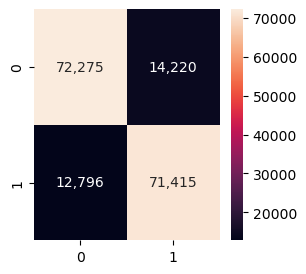

In [13]:
print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(label_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, _ = roc_curve(label_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

# Case of missed cleavage sites count

Test AUC : 0.8977566710693451
              precision    recall  f1-score   support

       False     0.8377    0.5839    0.6881     10970
        True     0.8946    0.9690    0.9303     40007

    accuracy                         0.8861     50977
   macro avg     0.8662    0.7764    0.8092     50977
weighted avg     0.8824    0.8861    0.8782     50977



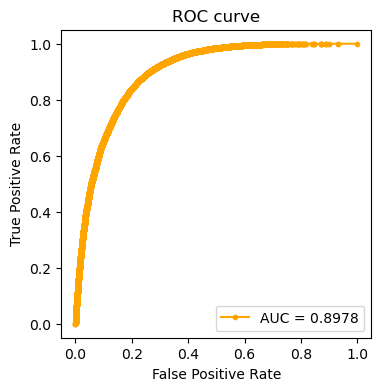

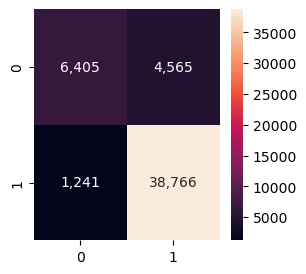

Test AUC : 0.8730941786996322
              precision    recall  f1-score   support

       False     0.7941    0.7683    0.7810     31745
        True     0.7853    0.8097    0.7973     33229

    accuracy                         0.7894     64974
   macro avg     0.7897    0.7890    0.7891     64974
weighted avg     0.7896    0.7894    0.7893     64974



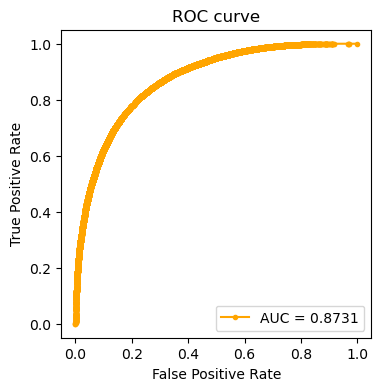

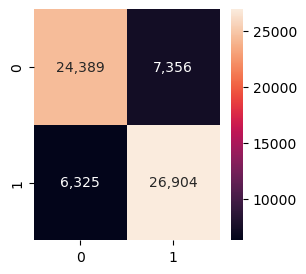

Test AUC : 0.8909099879184699
              precision    recall  f1-score   support

       False     0.8880    0.9475    0.9168     43780
        True     0.7142    0.5235    0.6041     10975

    accuracy                         0.8625     54755
   macro avg     0.8011    0.7355    0.7605     54755
weighted avg     0.8532    0.8625    0.8541     54755



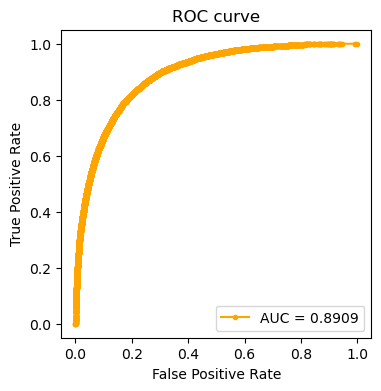

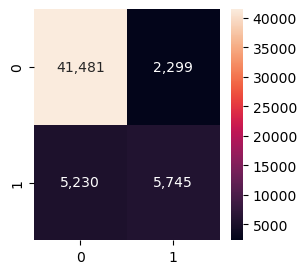

In [14]:
miss0_idx = df_test.loc[df_test.miss1=='ZZZZZZZZZZZZZZZ'].index
miss1_idx = df_test.loc[(df_test.miss1!='ZZZZZZZZZZZZZZZ') & (df_test.miss2=='ZZZZZZZZZZZZZZZ')].index
miss2_idx = df_test.loc[(df_test.miss1!='ZZZZZZZZZZZZZZZ') & (df_test.miss2!='ZZZZZZZZZZZZZZZ')].index

y_pred = np.array(y_pred)
probs_miss0 = probs[miss0_idx]
probs_miss1 = probs[miss1_idx]
probs_miss2 = probs[miss2_idx]
y_pred_miss0 = y_pred[miss0_idx]
y_pred_miss1 = y_pred[miss1_idx]
y_pred_miss2 = y_pred[miss2_idx]
label_test_miss0 = label_test[miss0_idx]
label_test_miss1 = label_test[miss1_idx]
label_test_miss2 = label_test[miss2_idx]

auc = roc_auc_score(label_test_miss0, probs_miss0)
print('Test AUC : {}'.format(auc))
print(classification_report(label_test_miss0, y_pred_miss0, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, _ = roc_curve(label_test_miss0, probs_miss0)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test_miss0, y_pred_miss0)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

auc = roc_auc_score(label_test_miss1, probs_miss1)
print('Test AUC : {}'.format(auc))
print(classification_report(label_test_miss1, y_pred_miss1, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, _ = roc_curve(label_test_miss1, probs_miss1)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test_miss1, y_pred_miss1)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

auc = roc_auc_score(label_test_miss2, probs_miss2)
print('Test AUC : {}'.format(auc))
print(classification_report(label_test_miss2, y_pred_miss2, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, _ = roc_curve(label_test_miss2, probs_miss2)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test_miss2, y_pred_miss2)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()



# Cross Species - Mouse

Loading input peptides
47321/47321 [==============================] - 745s 16ms/step - loss: 0.7691 - accuracy: 0.6746
Test Loss: 0.7691349387168884
Test Accuracy: 0.6745944023132324
Test AUC : 0.9114451485641821
              precision    recall  f1-score   support

       False     0.9967    0.6592    0.7936   1436847
        True     0.1318    0.9598    0.2317     77417

    accuracy                         0.6746   1514264
   macro avg     0.5642    0.8095    0.5126   1514264
weighted avg     0.9525    0.6746    0.7649   1514264



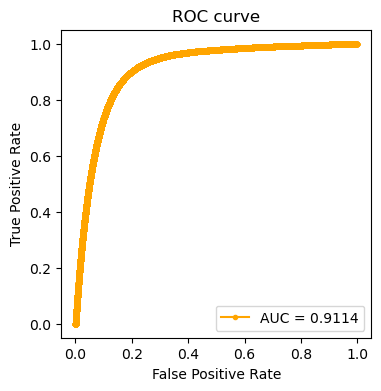

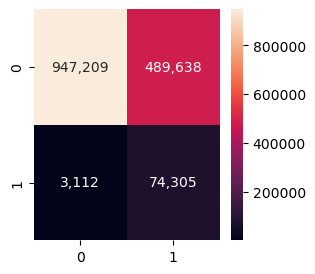

In [15]:
df_test = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/mouse/KLife/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/mouse/KLife/test.csv'),
])
df_test = df_test[df_test.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.nterm.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.cterm.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.miss1.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.miss2.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)

print('Loading input peptides')
pep_test, n_test, c_test, m1_test, m2_test, label_test = get_npy_DbyDeep(df_test)

probs = model.predict([pep_test, n_test, c_test, m1_test, m2_test])
y_pred = [1 if i>=0.5 else 0 for i in probs]
loss, acc = model.evaluate([pep_test, n_test, c_test, m1_test, m2_test], label_test)
auc = roc_auc_score(label_test, probs)

print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(label_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(label_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

Loading input peptides
41477/41477 [==============================] - 654s 16ms/step - loss: 0.7887 - accuracy: 0.6709
Test Loss: 0.788718581199646
Test Accuracy: 0.6708539724349976
Test AUC : 0.8883477177865504
              precision    recall  f1-score   support

       False     0.9953    0.6558    0.7907   1257916
        True     0.1313    0.9438    0.2305     69343

    accuracy                         0.6709   1327259
   macro avg     0.5633    0.7998    0.5106   1327259
weighted avg     0.9502    0.6709    0.7614   1327259



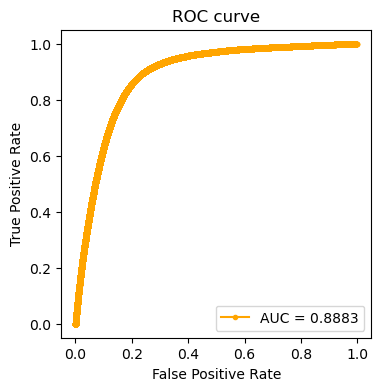

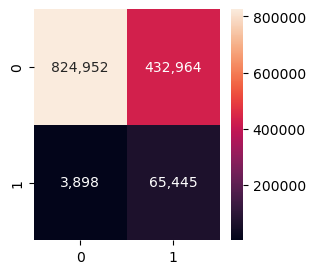

In [16]:
df_test = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/mouse/SkeletaMuscle/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/mouse/SkeletaMuscle/test.csv'),
])
df_test = df_test[df_test.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.nterm.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.cterm.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.miss1.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.miss2.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)

print('Loading input peptides')
pep_test, n_test, c_test, m1_test, m2_test, label_test = get_npy_DbyDeep(df_test)

probs = model.predict([pep_test, n_test, c_test, m1_test, m2_test])
y_pred = [1 if i>=0.5 else 0 for i in probs]
loss, acc = model.evaluate([pep_test, n_test, c_test, m1_test, m2_test], label_test)
auc = roc_auc_score(label_test, probs)

print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(label_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(label_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

# Cross Species - Human

Loading input peptides
62371/62371 [==============================] - 982s 16ms/step - loss: 0.7323 - accuracy: 0.6897
Test Loss: 0.7322553396224976
Test Accuracy: 0.689699649810791
Test AUC : 0.8871891118219749
              precision    recall  f1-score   support

       False     0.9931    0.6722    0.8017   1862789
        True     0.1692    0.9344    0.2865    133071

    accuracy                         0.6897   1995860
   macro avg     0.5811    0.8033    0.5441   1995860
weighted avg     0.9381    0.6897    0.7674   1995860



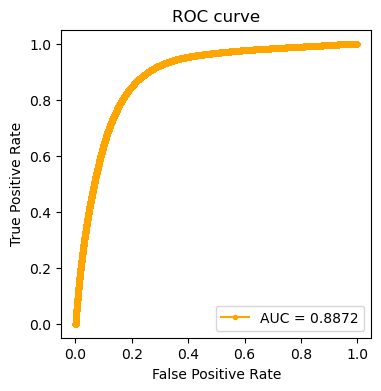

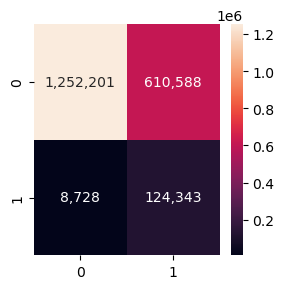

In [17]:
df_test = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/human/HEK293/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/human/HEK293/test.csv'),
])

print('Loading input peptides')
pep_test, n_test, c_test, m1_test, m2_test, label_test = get_npy_DbyDeep(df_test)

probs = model.predict([pep_test, n_test, c_test, m1_test, m2_test])
y_pred = [1 if i>=0.5 else 0 for i in probs]
loss, acc = model.evaluate([pep_test, n_test, c_test, m1_test, m2_test], label_test)
auc = roc_auc_score(label_test, probs)

print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(label_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(label_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

Loading input peptides
46799/46799 [==============================] - 737s 16ms/step - loss: 0.8245 - accuracy: 0.6573
Test Loss: 0.824458658695221
Test Accuracy: 0.6572619676589966
Test AUC : 0.8634587007193696
              precision    recall  f1-score   support

       False     0.9940    0.6478    0.7844   1441079
        True     0.0910    0.8995    0.1652     56470

    accuracy                         0.6573   1497549
   macro avg     0.5425    0.7737    0.4748   1497549
weighted avg     0.9599    0.6573    0.7610   1497549



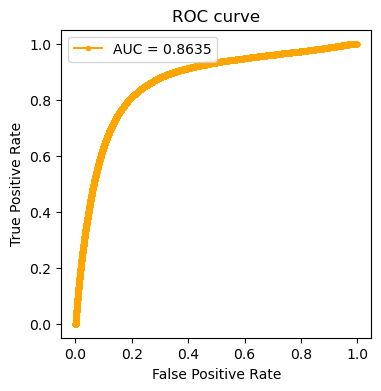

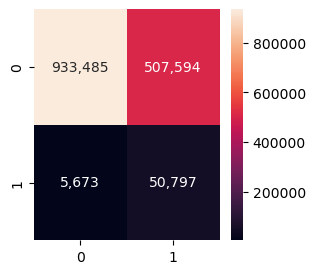

In [18]:
df_test = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/human/HmapLiver/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/human/HmapLiver/test.csv'),
])

print('Loading input peptides')
pep_test, n_test, c_test, m1_test, m2_test, label_test = get_npy_DbyDeep(df_test)

probs = model.predict([pep_test, n_test, c_test, m1_test, m2_test])
y_pred = [1 if i>=0.5 else 0 for i in probs]
loss, acc = model.evaluate([pep_test, n_test, c_test, m1_test, m2_test], label_test)
auc = roc_auc_score(label_test, probs)

print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(label_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(label_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

# Cross Species - Yeast

Loading input peptides
17349/17349 [==============================] - 278s 16ms/step - loss: 0.8178 - accuracy: 0.6622
Test Loss: 0.8178194165229797
Test Accuracy: 0.6621951460838318
Test AUC : 0.8734412037332302
              precision    recall  f1-score   support

       False     0.9931    0.6452    0.7822    521986
        True     0.1427    0.9293    0.2474     33160

    accuracy                         0.6622    555146
   macro avg     0.5679    0.7873    0.5148    555146
weighted avg     0.9423    0.6622    0.7503    555146



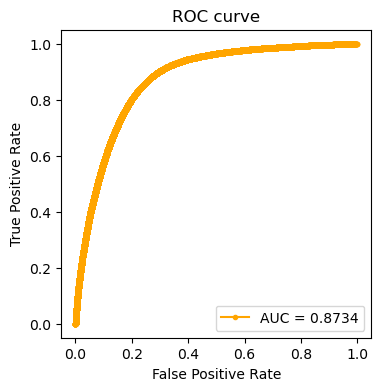

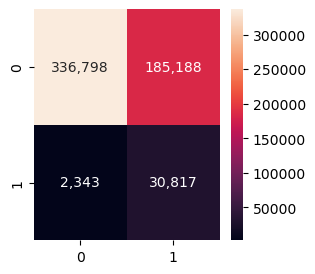

In [19]:
df_test = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/yeast/DelPBP1/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/yeast/DelPBP1/test.csv'),
])
df_test = df_test[df_test.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.nterm.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.cterm.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.miss1.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.miss2.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)

print('Loading input peptides')
pep_test, n_test, c_test, m1_test, m2_test, label_test = get_npy_DbyDeep(df_test)

probs = model.predict([pep_test, n_test, c_test, m1_test, m2_test])
y_pred = [1 if i>=0.5 else 0 for i in probs]
loss, acc = model.evaluate([pep_test, n_test, c_test, m1_test, m2_test], label_test)
auc = roc_auc_score(label_test, probs)

print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(label_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(label_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

Loading input peptides
20044/20044 [==============================] - 321s 16ms/step - loss: 0.6295 - accuracy: 0.7217
Test Loss: 0.6294824481010437
Test Accuracy: 0.7217233180999756
Test AUC : 0.913830021553148
              precision    recall  f1-score   support

       False     0.9877    0.6915    0.8135    562874
        True     0.2979    0.9385    0.4523     78520

    accuracy                         0.7217    641394
   macro avg     0.6428    0.8150    0.6329    641394
weighted avg     0.9033    0.7217    0.7693    641394



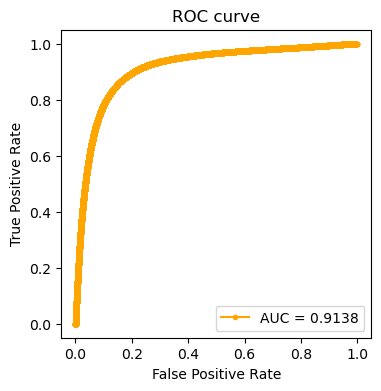

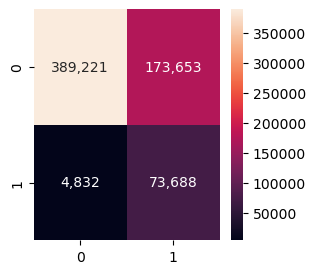

In [20]:
df_test = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/yeast/KLife/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/yeast/KLife/test.csv'),
])
df_test = df_test[df_test.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.nterm.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.cterm.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.miss1.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.miss2.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)

print('Loading input peptides')
pep_test, n_test, c_test, m1_test, m2_test, label_test = get_npy_DbyDeep(df_test)

probs = model.predict([pep_test, n_test, c_test, m1_test, m2_test])
y_pred = [1 if i>=0.5 else 0 for i in probs]
loss, acc = model.evaluate([pep_test, n_test, c_test, m1_test, m2_test], label_test)
auc = roc_auc_score(label_test, probs)

print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(label_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(label_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()